# *Panoptic Segmentation YOLOV9 (Gelan-C-Pan)*

In [ ]:
# Mount Drive Folder to Colab [Local]
from google.colab import drive
drive.mount("/content/gdrive")

!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov9-panoptic
!ls

In [32]:
%pip install -qr requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.9 MB/s eta 0:00:00


In [99]:
!python panoptic/predict.py --conf-thres 0.5 --source 'yolov9_panotic_ts/test_images/horse_racing.jpg' --img 640 --device 0 --weights 'yolov9_panotic_ts/gelan-c-pan.pt' --name gelan-c-pan --export-mask

panoptic/predict: weights=['yolov9_panotic_ts/gelan-c-pan.pt'], source=yolov9_panotic_ts/test_images/horse_racing.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=gelan-c-pan, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False, export_mask=True, color_map=data/color_map.pickle
YOLO 🚀 2024-6-6 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
gelan-c-pan summary: 419 layers, 27582573 parameters, 0 gradients, 146.7 GFLOPs
{'nc': 80, 'depth_multiple': 1.0, 'width_multiple': 1.0, 'anchors': 3, 'backbone': [[-1, 1, 'Conv', [64, 3, 2]], [-1, 1, 'Conv', [128, 3, 2]], [-1, 1, 'RepNCSPELAN4', [256, 128, 64, 1]], [-1, 1, 'ADown', [256]], [-1, 1, 'RepNC

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [100]:
result_image1 = "/content/gdrive/MyDrive/yolov9-panoptic/runs/predict-seg/gelan-c-pan"
result_image2 = "/content/gdrive/MyDrive/yolov9-panoptic/runs/predict-seg/gelan-c-pan2"
result_image3 = "/content/gdrive/MyDrive/yolov9-panoptic/runs/predict-seg/gelan-c-pan3"
result_image4 = "/content/gdrive/MyDrive/yolov9-panoptic/runs/predict-seg/gelan-c-pan4"
result_image5 = "/content/gdrive/MyDrive/yolov9-panoptic/runs/predict-seg/gelan-c-pan5"

original_image = "/content/gdrive/MyDrive/yolov9-panoptic/yolov9_panotic_ts/test_images/traffic.jpg"

Result Overlay Images:



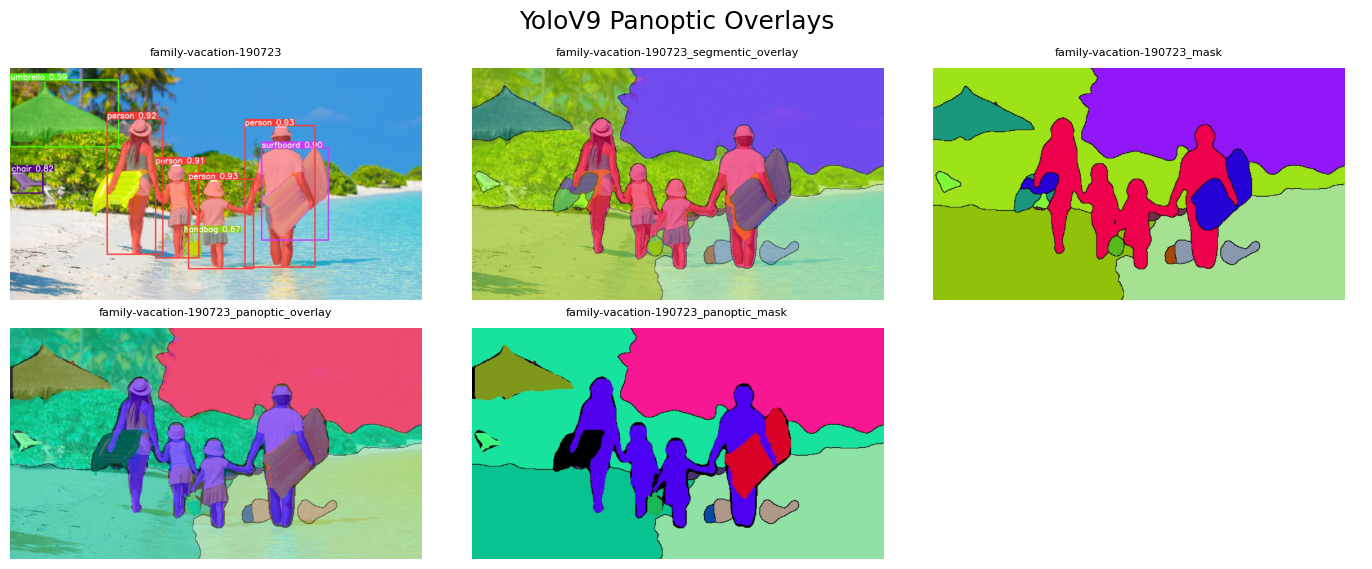

In [111]:
def show_overlays(result_file_path):
    files_res = [f for f in os.listdir(result_file_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    # calculate rows needed (3 images per row)
    row = math.ceil(len(files_res) / 3)

    fig, axes = plt.subplots(row, 3, figsize=(7 * row, 5.38))

    # if only one row, axes is 1D
    axes = axes.flatten() if row > 1 else axes

    for i, image_file in enumerate(files_res):
        image_path = os.path.join(result_file_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i].imshow(image)
        axes[i].set_title(os.path.splitext(files_res[i])[0], fontsize=8, pad=10)
        axes[i].axis('off')

    # hide any unused axes
    for j in range(len(files_res), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()           # removes padding around the whole figure
    fig.suptitle("YoloV9 Panoptic Overlays", fontsize=18, y=1.05)
    plt.show()


print(f"\033[92mResult Overlay Images:\033[0m\n")
show_overlays(result_image1)

# *Image Captions*

In [5]:
!pip install -q transformers

In [ ]:
# 1) Install needed libraries
!pip install keytotext --upgrade

In [ ]:
!pip install datasets==1.18.4

In [ ]:
!pip install evaluate

In [ ]:
import pathlib, importlib.util

# locate keytotext package
spec = importlib.util.find_spec("keytotext")
base_path = pathlib.Path(spec.origin).parent

# list all .py files
for file in base_path.rglob("*.py"):
    code = file.read_text()
    changed = False

    # 1. AdamW patch
    if "from transformers import (\n    AdamW," in code:
        code = code.replace(
            "from transformers import (\n    AdamW,",
            "from torch.optim import AdamW\nfrom transformers import ("
        )
        changed = True

    # 2. load_metric patch
    if "from datasets import load_metric" in code:
        code = code.replace(
            "from datasets import load_metric",
            "import evaluate"
        )
        code = code.replace(
            "load_metric(",
            "evaluate.load("
        )
        changed = True

    # 3. remove pad_to_max_length
    if "pad_to_max_length" in code:
        code = code.replace("pad_to_max_length=True", "")
        code = code.replace("pad_to_max_length = True", "")
        changed = True

    if changed:
        file.write_text(code)
        print(f"✅ Patched {file}")

print("✅ All keytotext patches applied")


In [ ]:
import pathlib

file_path = pathlib.Path("/usr/local/lib/python3.12/dist-packages/keytotext/models.py")

code = file_path.read_text()

# replace both styles
code = code.replace("pad_to_max_length=True", 'padding="max_length"')
code = code.replace("pad_to_max_length = True", 'padding="max_length"')

file_path.write_text(code)
print(f"✅ Patched {file_path}")


In [19]:
from transformers import PreTrainedTokenizerFast

# patch encode_plus
_orig_encode_plus = PreTrainedTokenizerFast.encode_plus
def patched_encode_plus(self, *args, **kwargs):
    kwargs.pop("pad_to_max_length", None)  # remove the old argument
    return _orig_encode_plus(self, *args, **kwargs)

PreTrainedTokenizerFast.encode_plus = patched_encode_plus

# patch _batch_encode_plus just in case
_orig_batch = PreTrainedTokenizerFast._batch_encode_plus
def patched_batch_encode_plus(self, *args, **kwargs):
    kwargs.pop("pad_to_max_length", None)
    return _orig_batch(self, *args, **kwargs)

PreTrainedTokenizerFast._batch_encode_plus = patched_batch_encode_plus

In [ ]:
from keytotext import pipeline

nlp = pipeline("mrm8488/t5-base-finetuned-common_gen")

nlp(['India','wedding','Food'])

In [104]:
def show_text_result_overlays(result_file_path):
    files_res = [f for f in os.listdir(result_file_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    files_txt = [f for f in os.listdir(result_file_path) if f.lower().endswith((".txt"))]


    # read caption from first txt file (if exists)
    keywords = []
    if files_txt:
        txt_path = os.path.join(result_file_path, files_txt[0])
        with open(txt_path, "r", encoding="utf-8") as txt:
            caps = txt.read().split('\n')
            keywords.append(caps)


    # calculate rows needed (3 images per row)
    row = math.ceil(len(files_res) / 3)

    fig, axes = plt.subplots(row, 3, figsize=(7 * row, 5.38))

    # if only one row, axes is 1D
    axes = axes.flatten() if row >= 1 else axes

    for i, image_file in enumerate(files_res):
        image_path = os.path.join(result_file_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i].imshow(image)
        axes[i].set_title(os.path.splitext(files_res[i])[0], fontsize=8, pad=10)
        axes[i].axis('off')

    # hide any unused axes
    for j in range(len(files_res), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    # caption
    if keywords:
        generated_sentence = nlp(keywords)
        fig.suptitle(generated_sentence, fontsize=18, y=1.08)

    plt.show()



Result Overlay Images:



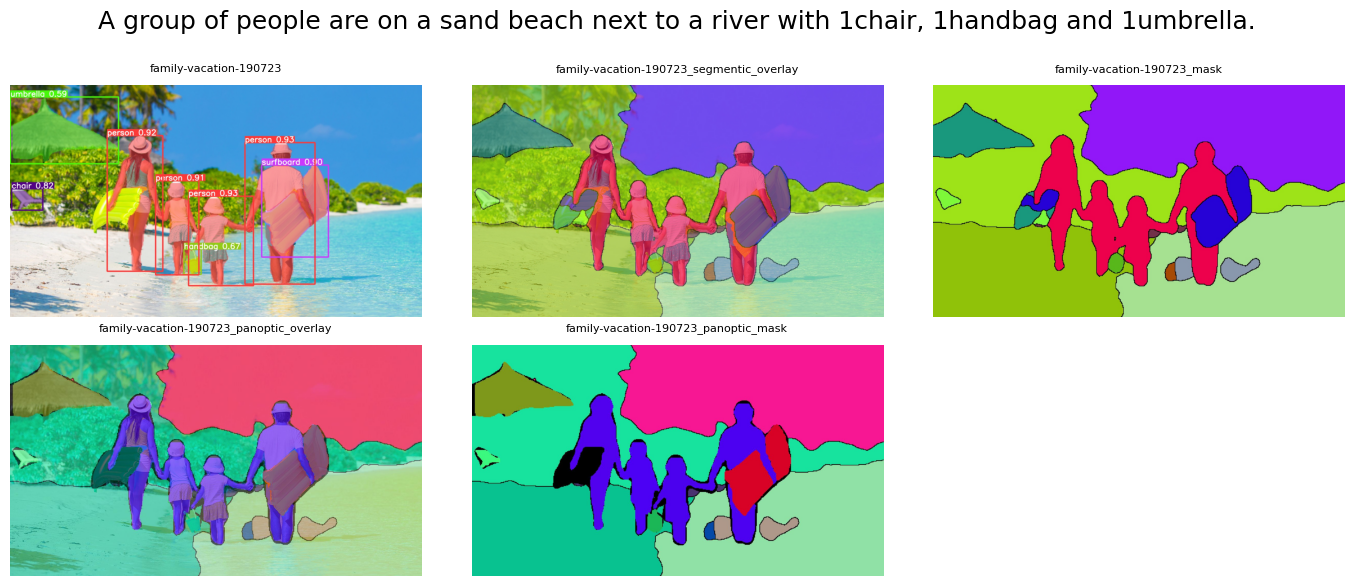

In [105]:
# Image 1
print(f"\033[92mResult Overlay Images:\033[0m\n")
show_text_result_overlays(result_image1)

Result Overlay Images:



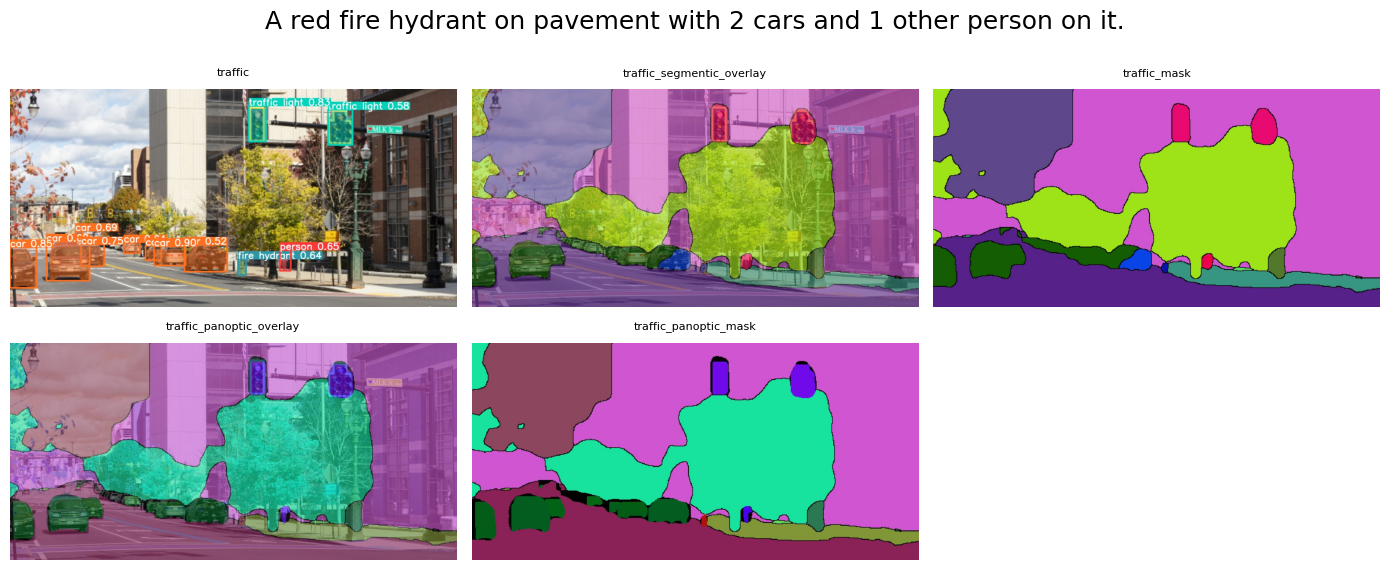

In [106]:
# Image 2
print(f"\033[92mResult Overlay Images:\033[0m\n")
show_text_result_overlays(result_image2)

Result Overlay Images:



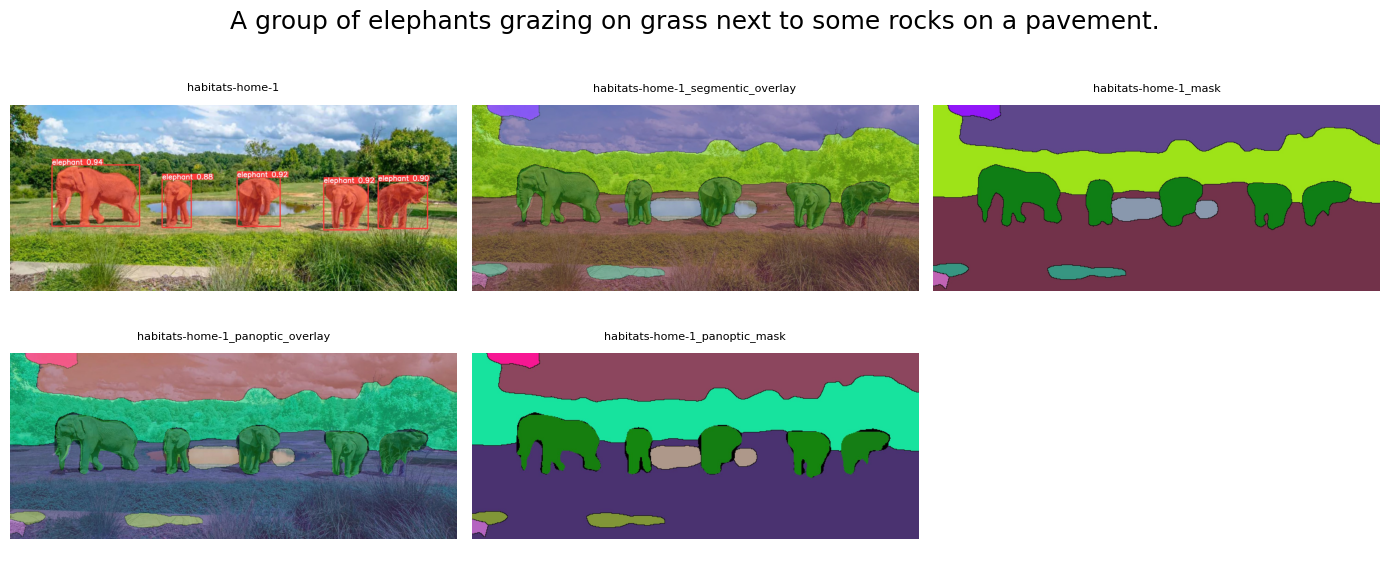

In [107]:
# Image 3
print(f"\033[92mResult Overlay Images:\033[0m\n")
show_text_result_overlays(result_image3)

Result Overlay Images:



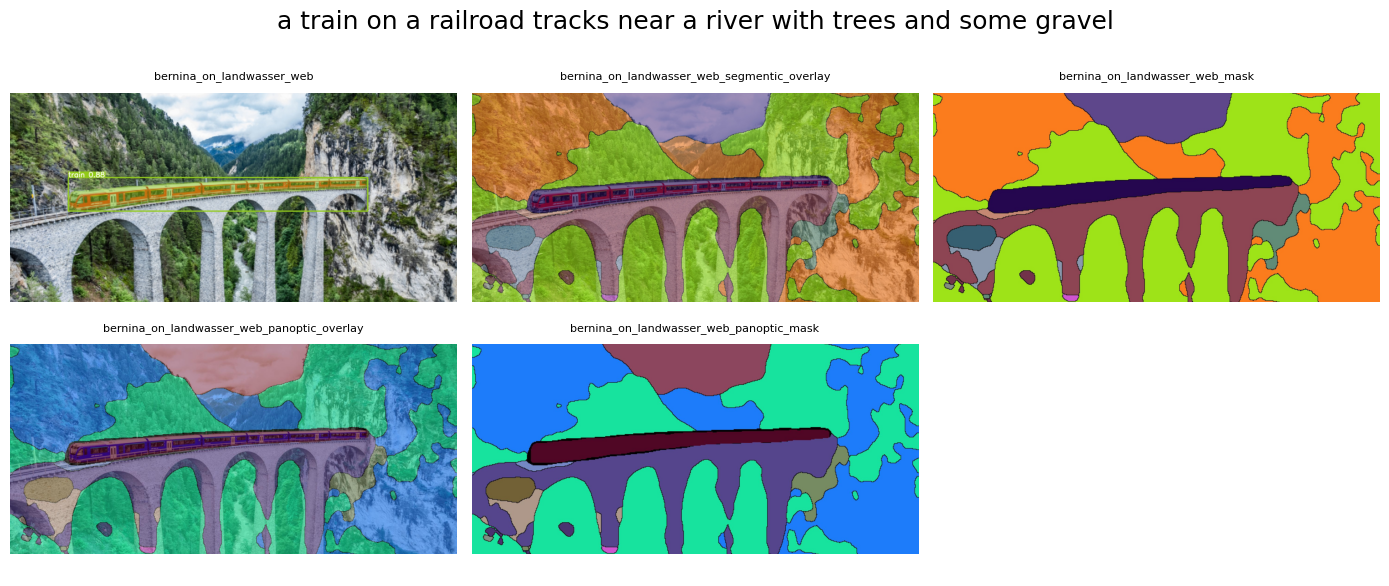

In [108]:
# Image 4
print(f"\033[92mResult Overlay Images:\033[0m\n")
show_text_result_overlays(result_image4)

Result Overlay Images:



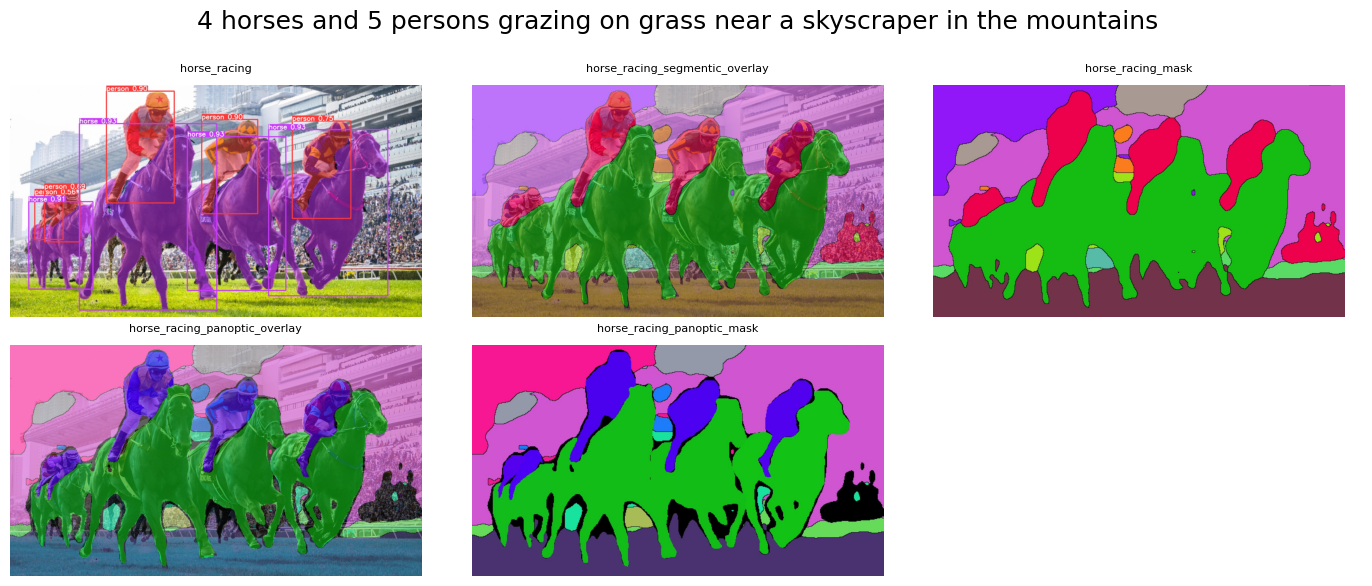

In [110]:
# Image 5
print(f"\033[92mResult Overlay Images:\033[0m\n")
show_text_result_overlays(result_image5)